In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from six.moves import cPickle as pickle
from scipy.misc import imread
import platform
from tensorflow.keras.datasets import cifar10

%matplotlib inline

In [2]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte


def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000,
                     subtract_mean=True):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    # Load the raw CIFAR-10 data
    (X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    Y_val = Y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    Y_train = Y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    Y_test = Y_test[mask]

    # Normalize the data: subtract the mean image
    if subtract_mean:
        mean_image = np.mean(X_train, axis=0)
        X_train -= mean_image
        X_val -= mean_image
        X_test -= mean_image

    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    # Package data into a dictionary
    return {
      'X_train': X_train, 'Y_train': Y_train,
      'X_val': X_val, 'Y_val': Y_val,
      'X_test': X_test, 'Y_test': Y_test,
    }

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

In [3]:

def sample_noise(batch_size, dim):
    
    return tf.random_uniform((batch_size, dim), -1, 1, tf.float32)

In [4]:
def leaky_relu(x):
    return tf.nn.leaky_relu(x, alpha=0.01)

In [5]:
def discriminator(x):
    with tf.variable_scope("discriminator"):
        W1 = tf.get_variable("W1", shape=[64*6*6, 64*6*6])
        b1 = tf.get_variable("b1", shape=[64*6*6])
        W2 = tf.get_variable("W2", shape=[64*6*6, 1])
        b2 = tf.get_variable("b2", shape=[1])
        
        x = tf.reshape(x, [-1, 32, 32, 3])

        conv1 = tf.layers.conv2d(
            inputs=x, 
            filters=32, 
            kernel_size=[5,5], 
            strides=(1, 1),
            padding='valid',
            activation=leaky_relu
        )
        
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
        
        # bn1 = tf.layers.batch_normalization(pool1, training=training)
        conv2 = tf.layers.conv2d(
            inputs=pool1,
            filters=64,
            kernel_size=[3,3],
            strides=(1,1),
            padding='valid',
            activation=leaky_relu
        )
        
        pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
        
        # bn2 = tf.layers.batch_normalization(pool1, training=training)
        
        pool2_flat = tf.layers.flatten(pool2)
        
        fc1 = tf.matmul(pool2_flat, W1) + b1
        
        lrelu1 = leaky_relu(fc1)
        
        logits = tf.matmul(lrelu1, W2) + b2
        
        return logits

In [6]:
def generator(z):
    _, noise_dim = z.shape
    with tf.variable_scope("generator"):
        # TODO: implement architecture

        W1 = tf.get_variable("W1", shape=[noise_dim, 1600])
        b1 = tf.get_variable("b1", shape=[1600])
        
        W2 = tf.get_variable("W2", shape=[1600, 8*8*384])
        b2 = tf.get_variable("b2", shape=[8*8*384])

        fc1 = tf.matmul(z, W1) + b1
        
        relu1 = tf.nn.relu(fc1)
        
        bn1 = tf.layers.batch_normalization(relu1)
        
        fc2 = tf.matmul(bn1, W2) + b2
        
        relu2 = tf.nn.relu(fc2)
        
        bn2 = tf.layers.batch_normalization(relu2)
        
        img_shape = tf.reshape(bn2, [-1, 8, 8, 384])
        
        conv2dt1 = tf.layers.conv2d_transpose(
            inputs=img_shape,
            filters=192,
            kernel_size=[4,4],
            strides=(2, 2),
            padding='same',
            activation=tf.nn.relu,
        )
        
        bn3 = tf.layers.batch_normalization(conv2dt1)
        
        img = tf.layers.conv2d_transpose(
            inputs=bn3,
            filters=3,
            kernel_size=[4,4],
            strides=(2, 2),
            padding='same',
            activation=tf.nn.tanh,
        )

        img = tf.reshape(img, [-1, 3*32*32])
        return img

In [7]:
def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    N = score_real.shape[0]

    D_loss = 0.5 * (tf.reduce_mean(tf.pow(score_real - tf.ones_like(score_real), 2)) + tf.reduce_mean(tf.pow(score_fake, 2)))
    G_loss = 0.5 * tf.reduce_mean(tf.pow(score_fake - tf.ones_like(score_fake), 2))
    
    return D_loss, G_loss

In [8]:
def wgan_loss(logits_real, logits_fake, batch_size, x, G_sample):
    d_loss = - tf.reduce_mean(logits_real) + tf.reduce_mean(logits_fake)
    g_loss = - tf.reduce_mean(logits_fake)
    
    lam = 10
    
    eps = tf.random_uniform([batch_size, 1], minval=0.0, maxval=1.0)
    x_h = eps * x + (1 - eps) * G_sample
    
    with tf.variable_scope("", reuse=True) as scope:
        grad_d_x_h = tf.gradients(discriminator(x_h), x_h)
        
    grad_norm = tf.norm(grad_d_x_h[0], axis=1, ord='euclidean')
    grad_pen = tf.reduce_mean(tf.square(grad_norm-1))
    
    d_loss += lam * grad_pen
    
    return d_loss, g_loss

In [9]:
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver

In [10]:
def get_next_batch(batch_size, previous):
    if previous + batch_size >= X_train.shape[0]:
        previous = 0
    x = X_train[previous:previous+batch_size,:,:,:]
    x = x.reshape([-1, 3072])
    y = Y_train[previous:previous+batch_size]
    previous += batch_size
    return x, y, previous

def show_images(images):
    images = np.reshape(images, [images.shape[0], 32, 32, 3])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1] / 3)))

    N = images.shape[0]
    n = N // 5
    fig, axes1 = plt.subplots(n,5,figsize=(12, 12))
    images = deprocess_img(images)
    images = images.astype('uint8')
    for j in range(n):
        for k in range(5):
            if j*5+k < N:
                axes1[j][k].set_axis_off()
                axes1[j][k].imshow(images[j*5+k])
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1] / 3)))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg,3]))
    return

def preprocess_img(x):
    return 2 * (x / 255.0) - 1

def deprocess_img(x):
    return ((x + 1) / 2.0 * 256.0)

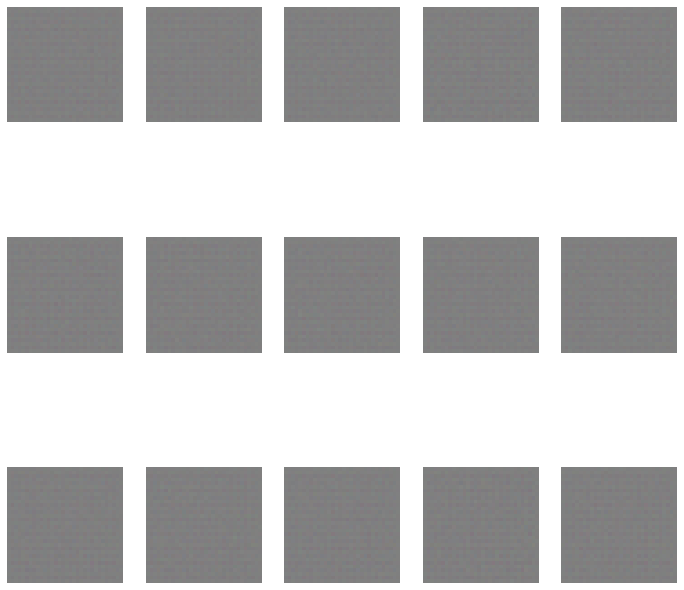

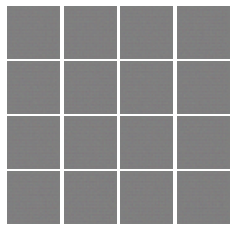


Iter: 0, D: 0.6098, G:0.05271
Iter: 50, D: 0.2004, G:0.2742
Iter: 100, D: 0.3372, G:0.4338
Iter: 150, D: 0.1961, G:0.3914
Iter: 200, D: 0.3149, G:0.268


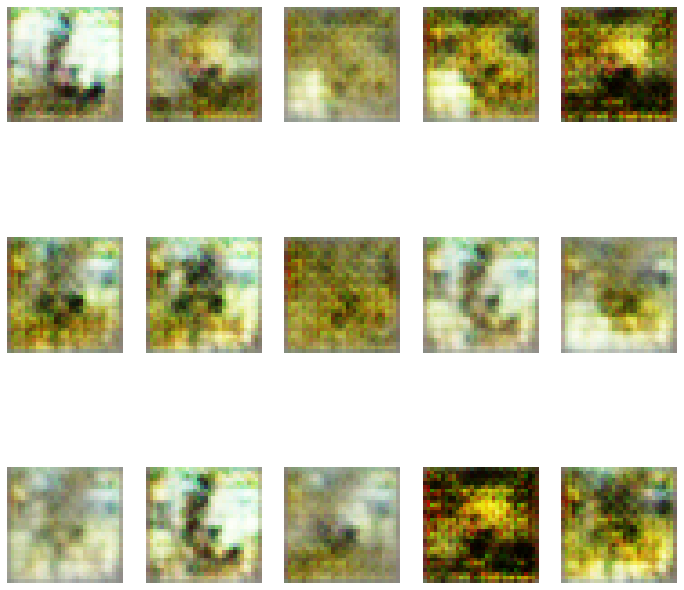

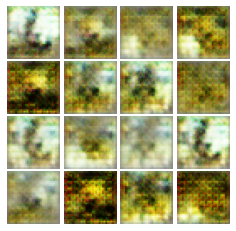


Iter: 250, D: 0.2477, G:0.3567
Iter: 300, D: 0.2435, G:0.2395
Iter: 350, D: 0.2511, G:0.2204
Iter: 400, D: 0.2127, G:0.3668
Iter: 450, D: 0.239, G:0.2755


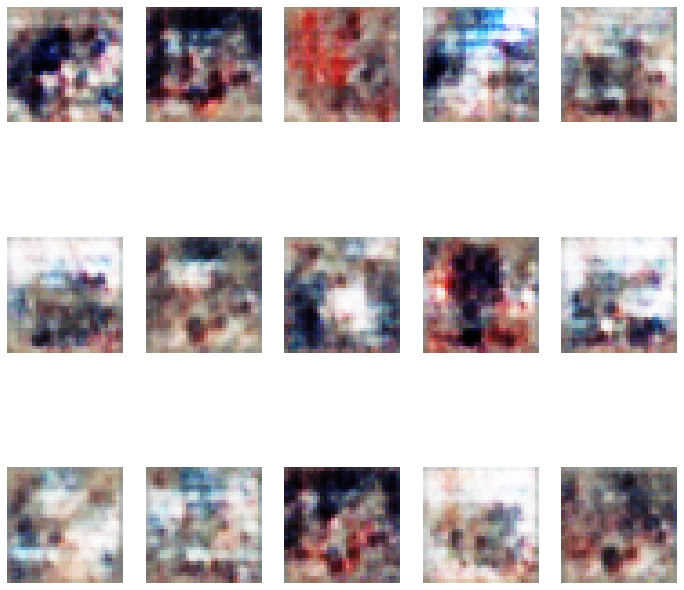

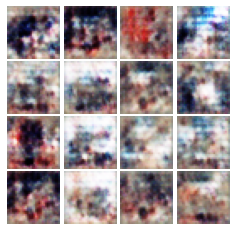


Iter: 500, D: 0.2486, G:0.2983
Iter: 550, D: 0.2057, G:0.2232
Iter: 600, D: 0.2045, G:0.3026
Iter: 650, D: 0.2822, G:0.1975
Iter: 700, D: 0.2105, G:0.2189


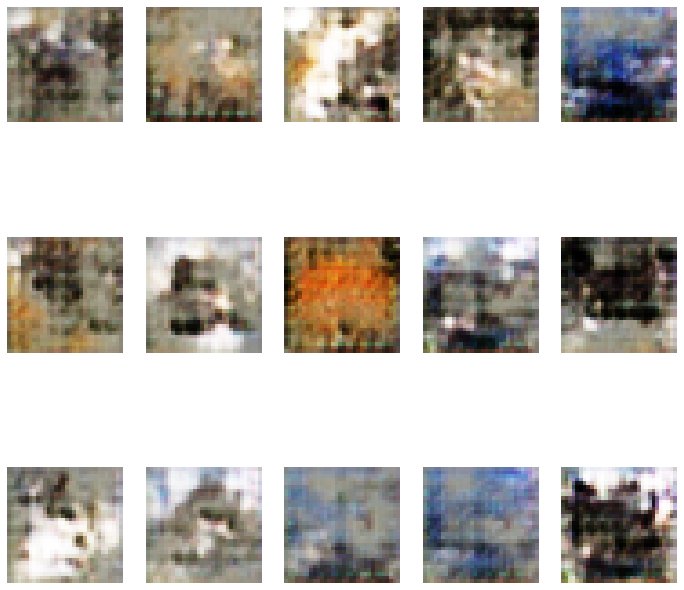

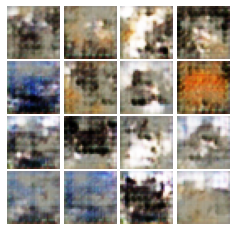


Iter: 750, D: 0.2181, G:0.2779
Iter: 800, D: 0.2087, G:0.2173
Iter: 850, D: 0.1962, G:0.2864
Iter: 900, D: 0.1937, G:0.186
Iter: 950, D: 0.1957, G:0.2353


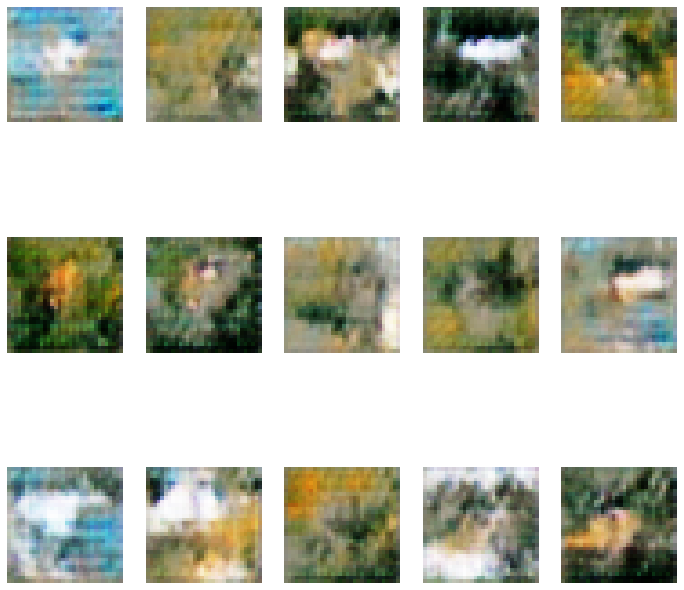

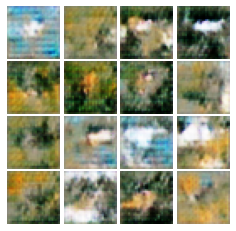


Iter: 1000, D: 0.243, G:0.1971
Iter: 1050, D: 0.2087, G:0.2261
Iter: 1100, D: 0.2046, G:0.214
Iter: 1150, D: 0.2294, G:0.2099
Iter: 1200, D: 0.2005, G:0.2412


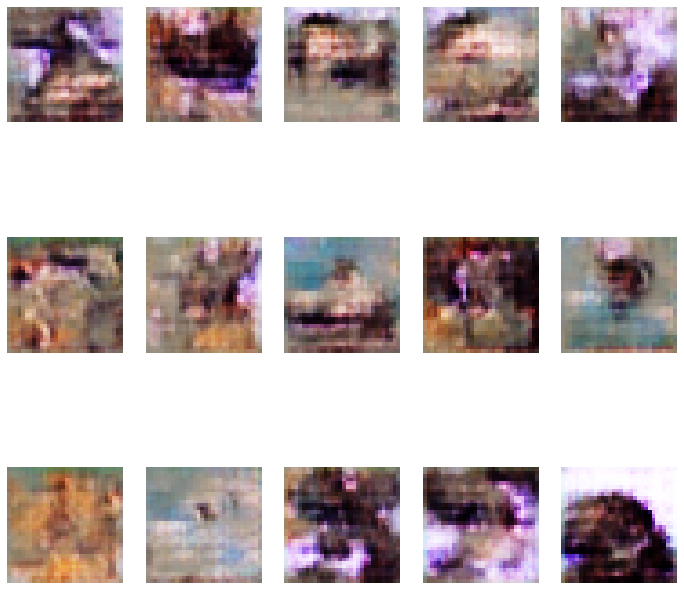

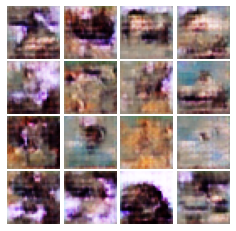


Iter: 1250, D: 0.219, G:0.1708
Iter: 1300, D: 0.232, G:0.2263
Iter: 1350, D: 0.1873, G:0.1974
Iter: 1400, D: 0.19, G:0.2149
Iter: 1450, D: 0.1837, G:0.2034


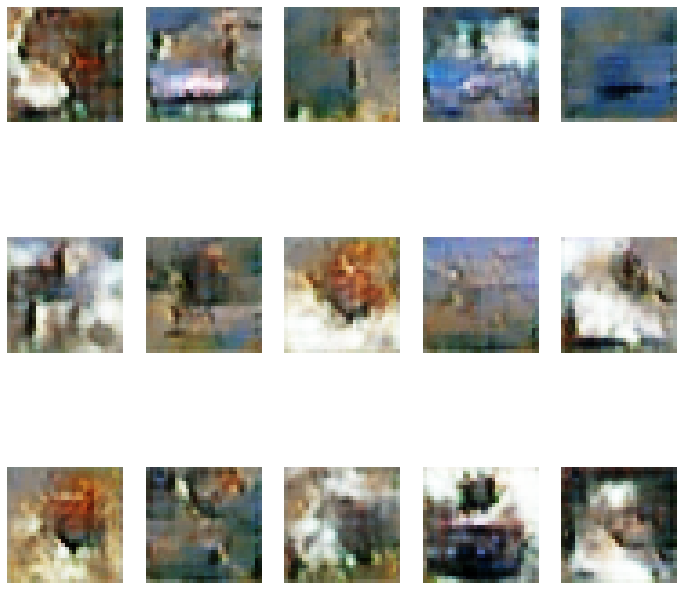

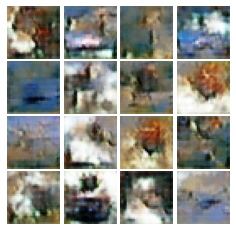


Iter: 1500, D: 0.2216, G:0.247
Iter: 1550, D: 0.2326, G:0.2158
Iter: 1600, D: 0.1861, G:0.2184
Iter: 1650, D: 0.2179, G:0.2136
Iter: 1700, D: 0.2126, G:0.2066


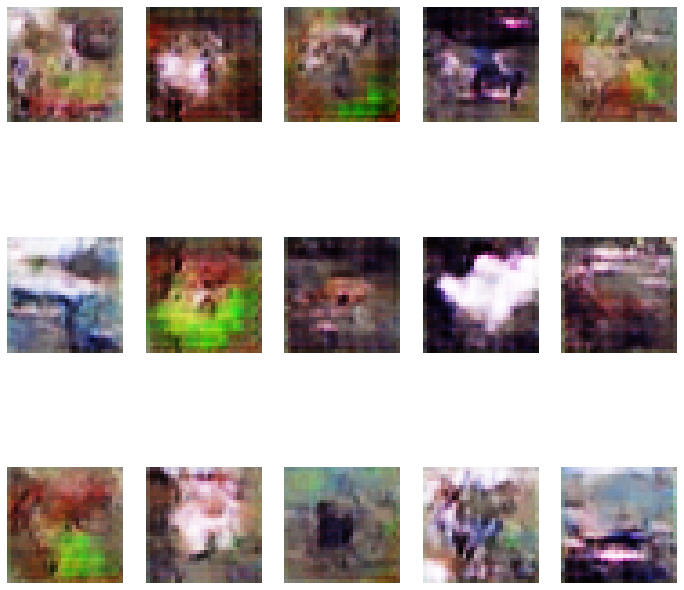

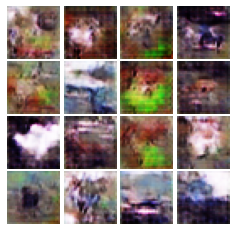


Iter: 1750, D: 0.1822, G:0.2278
Iter: 1800, D: 0.1818, G:0.2234
Iter: 1850, D: 0.2025, G:0.2083
Iter: 1900, D: 0.205, G:0.2076
Iter: 1950, D: 0.213, G:0.1971


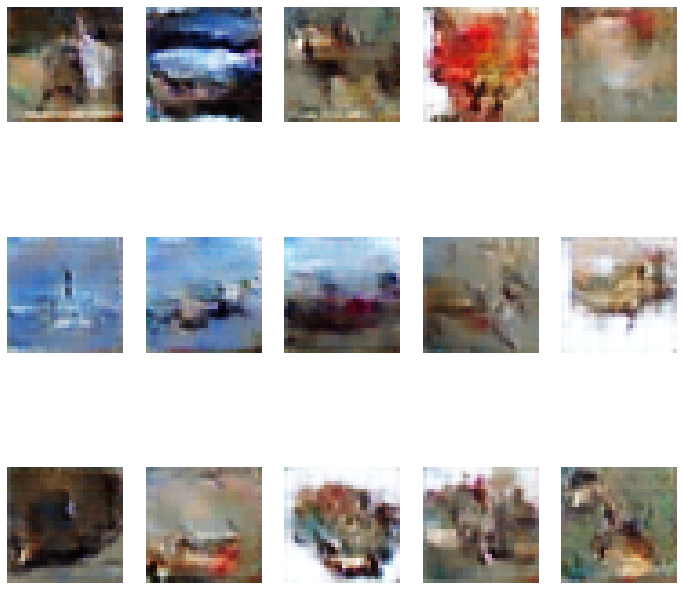

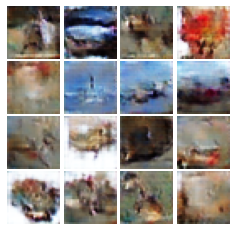


Iter: 2000, D: 0.1966, G:0.287
Iter: 2050, D: 0.1868, G:0.2104
Iter: 2100, D: 0.1738, G:0.2534
Iter: 2150, D: 0.1694, G:0.2124
Iter: 2200, D: 0.1873, G:0.2482


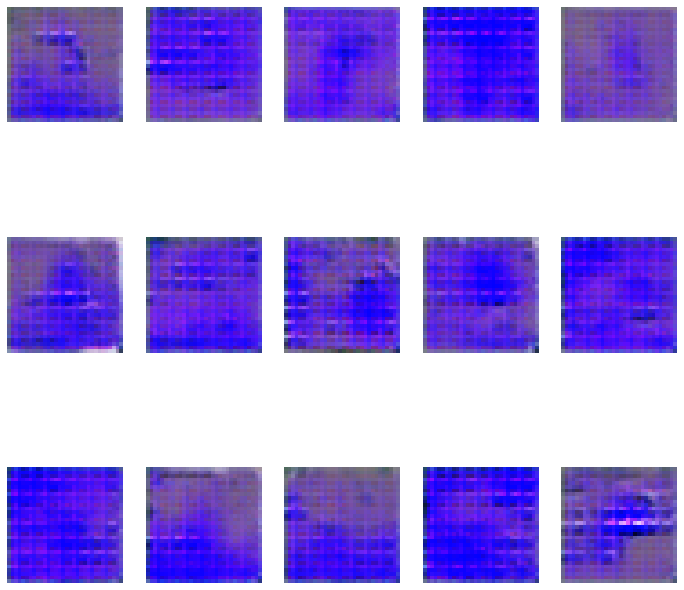

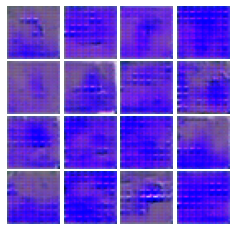


Iter: 2250, D: 8.008, G:71.08
Iter: 2300, D: 0.1979, G:0.04782
Iter: 2350, D: 0.2154, G:0.19
Iter: 2400, D: 0.1956, G:0.3084
Iter: 2450, D: 0.1882, G:0.3608


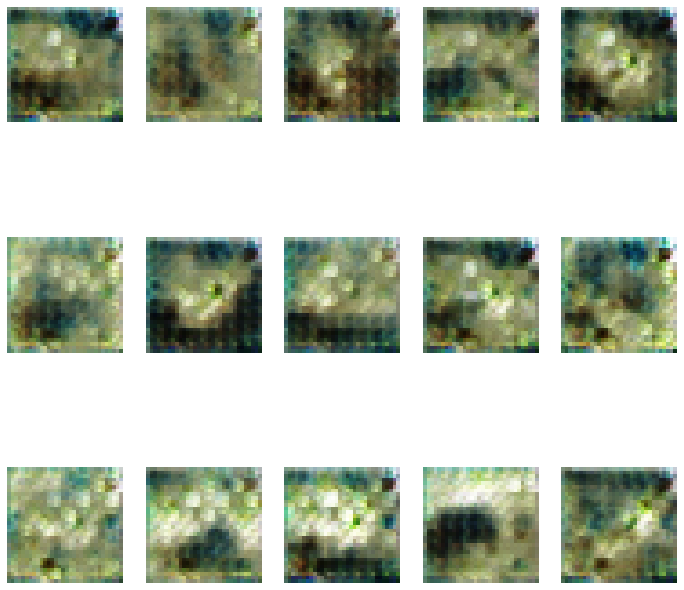

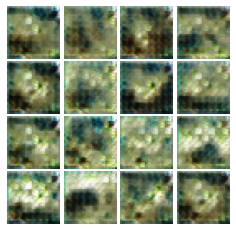


Iter: 2500, D: 0.1683, G:0.229
Iter: 2550, D: 0.1902, G:0.2181
Iter: 2600, D: 0.2454, G:0.1362
Iter: 2650, D: 0.2076, G:0.2134
Iter: 2700, D: 0.2063, G:0.1562


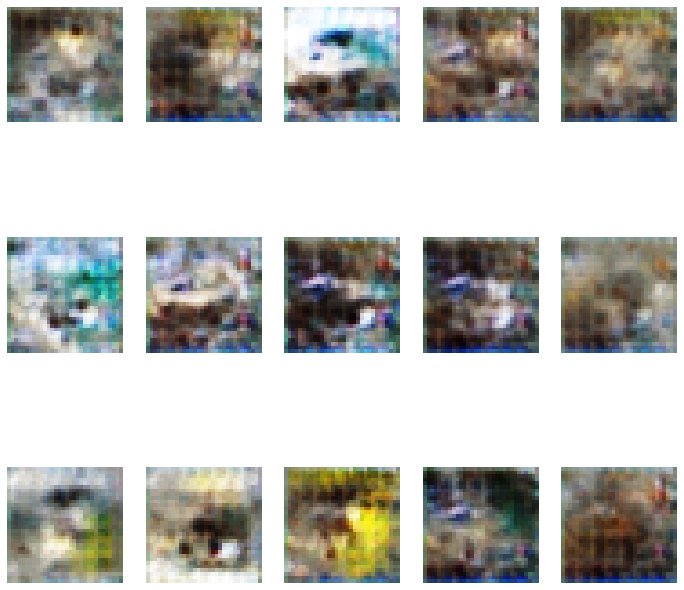

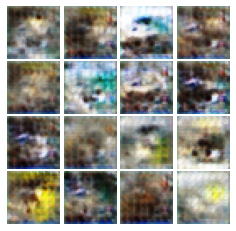


Iter: 2750, D: 0.1917, G:0.1823
Iter: 2800, D: 0.2009, G:0.2557
Iter: 2850, D: 0.2061, G:0.1774
Iter: 2900, D: 0.2205, G:0.1723
Iter: 2950, D: 0.2106, G:0.2418


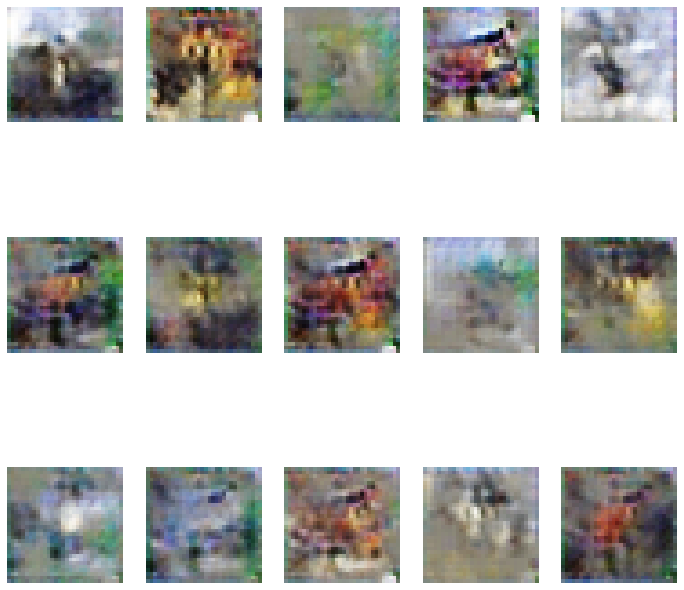

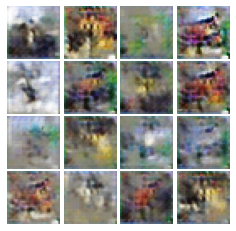


Iter: 3000, D: 0.2442, G:0.1666
Iter: 3050, D: 0.2106, G:0.1683
Iter: 3100, D: 0.2004, G:0.1976
Iter: 3150, D: 0.2535, G:0.1815
Iter: 3200, D: 0.249, G:0.1196


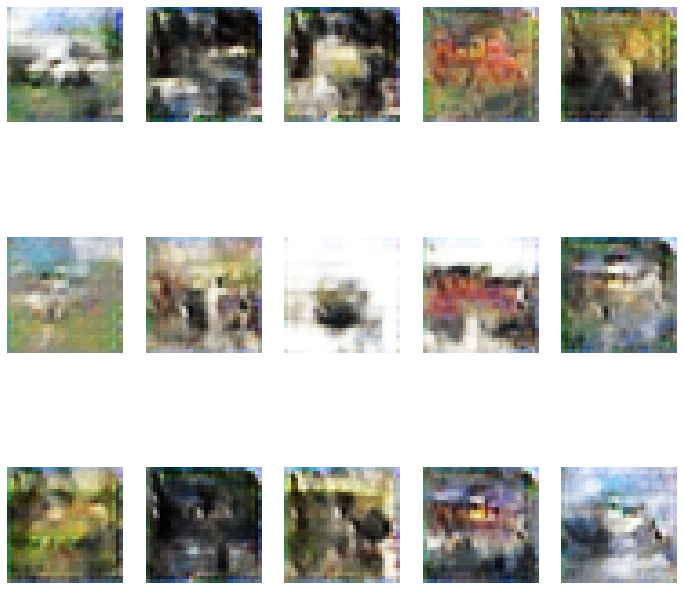

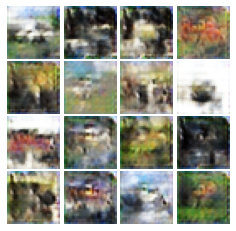


Iter: 3250, D: 0.2713, G:0.1592
Iter: 3300, D: 0.2286, G:0.1862
Iter: 3350, D: 0.212, G:0.1351
Iter: 3400, D: 0.2272, G:0.2419
Iter: 3450, D: 0.2225, G:0.1814


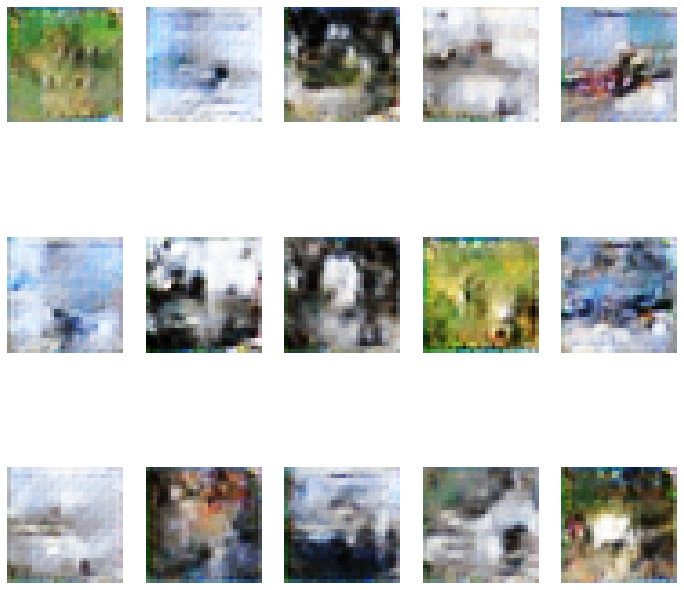

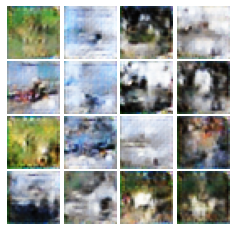


Iter: 3500, D: 0.2189, G:0.1927
Iter: 3550, D: 0.2027, G:0.2079
Iter: 3600, D: 0.227, G:0.2117
Iter: 3650, D: 0.2043, G:0.196
Iter: 3700, D: 0.2162, G:0.1984


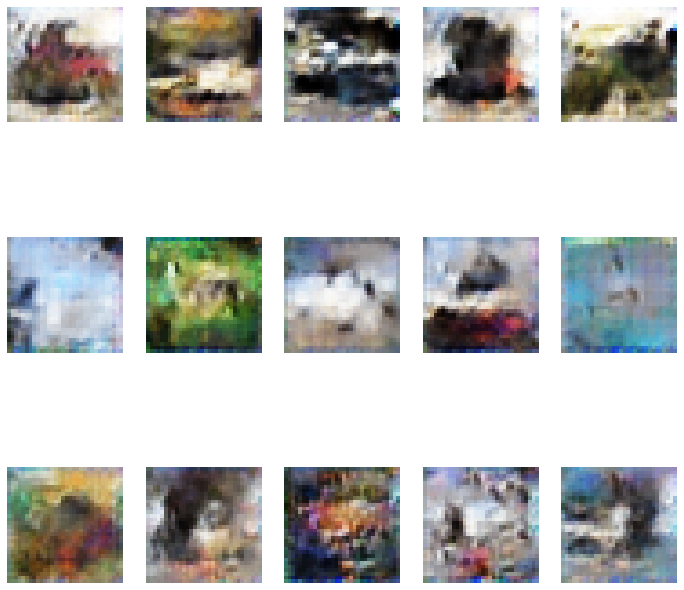

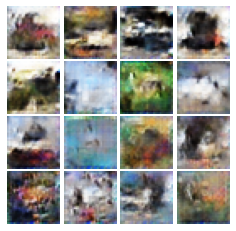


Iter: 3750, D: 0.238, G:0.2278
Iter: 3800, D: 0.2017, G:0.1831
Iter: 3850, D: 0.2397, G:0.123
Iter: 3900, D: 0.1873, G:0.2101
Final images


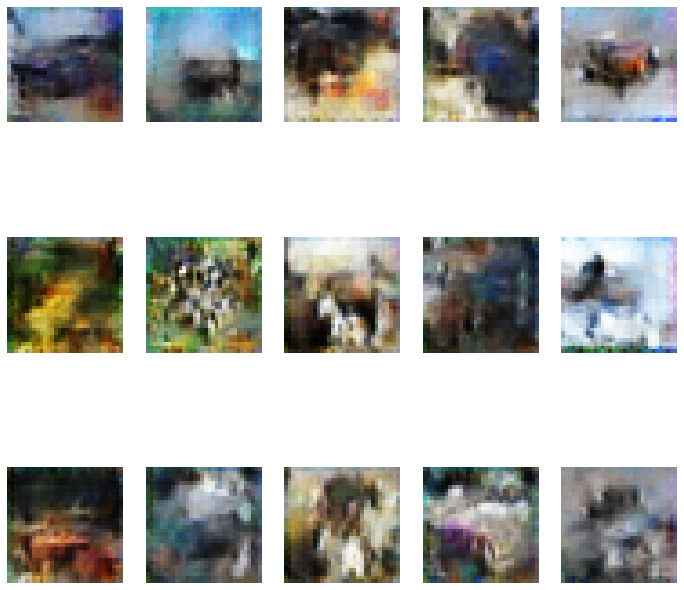

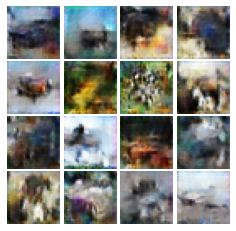

In [12]:
tf.reset_default_graph()

batch_size = 128
noise_dim = 288
num_epoch = 10
max_iter = int(X_train.shape[0]*num_epoch/batch_size)
show_every=250
print_every=50
previous = 0

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 3072])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
# D_loss, G_loss = wgan_loss(logits_real, logits_fake, batch_size, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()

    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y,previous = get_next_batch(batch_size, previous)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G:{:.4}'.format(it,D_loss_curr,G_loss_curr))
            saver.save(sess, "model/checkpoint.chkpt")
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()

In [15]:
iii = sess.run(G_sample, z)
iii = (iii + 1)/2


RuntimeError: Attempted to use a closed Session.